device is cuda:0


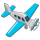

seed shape is torch.Size([72, 72, 16])


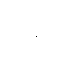

In [6]:
# Neural CA | Sam Greydanus | 2020
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time, PIL.Image, io, requests, copy

from original_utils import *

device_id = 0
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

# Global Params (my own)
CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🛩"

USE_PATTERN_POOL = True # set in "persistent" mode

# Load target image
target_img = load_emoji(TARGET_EMOJI)
imshow(target_img)

p = TARGET_PADDING
target_img_tensor = torch.tensor(target_img)
pad_target = torch.nn.functional.pad(target_img_tensor, (0, 0, p, p, p, p))
h, w = pad_target.shape[:2]
seed = torch.zeros(h, w, CHANNEL_N, dtype=torch.float32)
seed[h//2, w//2, 3:] = 1.0
print(f'seed shape is {seed.shape}')

imshow(to_rgba(seed))

In [38]:
def reshape(tensor, channels_last=True):
    """Reshape input torch tensor to (B, H, W, C) if 
        channels_last is true, and to (B, C, H, W) otherwise
    """
    if channels_last:
        return tensor.permute(0, 2, 3, 1)
    else:
        return tensor.permute(0, -1, 1, 2)
    
# Unit tests
channels_last_tensor = torch.randn(8, 40, 40, 16)
channels_first_tensor = torch.randn(8, 16, 40, 40)
assert channels_last_tensor.shape == reshape(channels_first_tensor).shape
assert channels_first_tensor.shape == reshape(channels_last_tensor, channels_last=False).shape

(1, 4, 72, 72) <class 'numpy.ndarray'>
(1, 72, 72, 4)


/tmp/ipykernel_3321171/3762432386.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img.thumbnail((40,40), PIL.Image.ANTIALIAS)


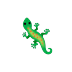

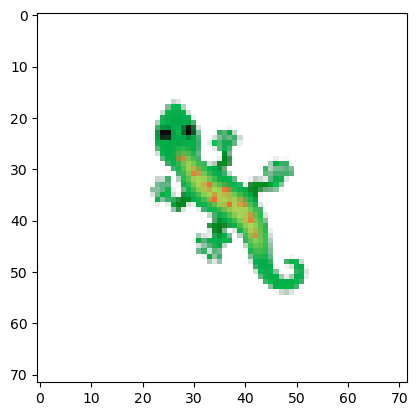

In [9]:
def get_dataset(k=16):
  r = requests.get('https://greydanus.github.io/files/lizard_1f98e.png')
  img = PIL.Image.open(io.BytesIO(r.content))  # get image: emoji_u1f98e (🦎)
  img.thumbnail((40,40), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0                  # convert image to NumPy array
  img *= img[..., 3:]                          # premultiply RGB by alpha
  img = img.transpose(2,0,1)[None,...]         # axes are [N, C, H, W]
  return {'y': np.pad(img, ((0,0),(0,0),(k,k),(k,k)))}  # pad image

y = get_dataset()
test_y = y['y']
print(test_y.shape, type(test_y))
y_reshaped = np.transpose(test_y, (0, 2, 3, 1))
print(y_reshaped.shape)
assert y_reshaped.shape == (1, 72, 72, 4)
plt.imshow(y_reshaped[0, ...])
imshow(y_reshaped[0])

In [10]:
# Implement the Neural Cellular Automata as a PyTorch module
class CA(nn.Module): 
  def __init__(self, state_dim=CHANNEL_N, hidden_dim=128):
    super(CA, self).__init__()
    self.state_dim = state_dim
    self.update = nn.Sequential(nn.Conv2d(state_dim, 3*state_dim, 3, padding=1, groups=state_dim, bias=False),  # perceive
                                nn.Conv2d(3*state_dim, hidden_dim, 1),  # process perceptual inputs
                                nn.ReLU(),                              # nonlinearity
                                nn.Conv2d(hidden_dim, state_dim, 1))    # output a residual update
    self.update[-1].weight.data *= 0  # initial residual updates should be close to zero
    
    # First conv layer will use fixed Sobel filters to perceive neighbors
    identity = np.outer([0, 1, 0], [0, 1, 0])       # identity filter
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0      # Sobel x filter
    kernel = np.stack([identity, dx, dx.T], axis=0) # stack (identity, dx, dy) filters
    kernel = np.tile(kernel, [state_dim,1,1])       # tile over channel dimension
    self.update[0].weight.data[...] = torch.Tensor(kernel)[:,None,:,:]
    self.update[0].weight.requires_grad = False
  
  def forward(self, x, num_steps):
    alive_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1
    frames = []
    for i in range(num_steps):
      alive_mask_pre = alive_mask(alpha=x[:,3:4])
      update_mask = torch.rand(*x.shape, device=x.device) > 0.5  # run a state update 1/2 of time
      x = x + update_mask * self.update(x)                       # state update!
      x = x * alive_mask_pre * alive_mask(alpha=x[:,3:4])        # a cell is either living or dead
      frames.append(x.clone())
    return torch.stack(frames) # axes: [N, B, C, H, W] where N is # of steps


In [19]:
def normalize_grads(model):  # makes training more stable, especially early on
  for p in model.parameters():
      p.grad = p.grad / (p.grad.norm() + 1e-8) if p.grad is not None else p.grad

def train(model, pad_target, n_steps=1001):
  model = model.to(device)  # put the model on GPU
  optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500], gamma=0.25)

  # target_rgba = torch.Tensor(pad_target['y']).to(device)  # put the target image on GPU
  target_rgba = torch.repeat_interleave(pad_target[None, ...], BATCH_SIZE, dim=0)
  target_rgba = pad_target[None, ...]
  target_rgba = target_rgba.permute(0, -1, 1, 2).contiguous()
  # print(f"target_rgba shape is {target_rgba.shape}")
  # assert target_rgba.shape == (1, 4, 72, 72)
                                            
  init_state = torch.zeros(BATCH_SIZE, CHANNEL_N, *target_rgba.shape[-2:]).to(device)

  return init_state

  # print(f"init_state is shape {init_state.shape}")

  init_state[..., init_state.shape[-2]//2, init_state.shape[-1]//2] = 1.  # initially, there is just one cell
  pool = init_state[:1].repeat(POOL_SIZE,1,1,1)
  
  loss_log = []

  for step in range(n_steps):

    # prepare batch, perturb, and run forward pass
    if POOL_SIZE > 0:  # draw CAs from pool (if we have one)
      pool_ixs = np.random.randint(POOL_SIZE, size=[BATCH_SIZE])
      input_states = pool[pool_ixs]
    else:
      input_states = init_state
    # if args.perturb_n > 0:  # perturb CAs (if desired)
    #   perturb = make_circle_masks(args.perturb_n, *init_state.shape[-2:])[:, None, ...]
    #   input_states[-args.perturb_n:] *= perturb.to(args.device)

    # print(f'input states before model shape is {input_states.shape}')
    states = model(input_states, np.random.randint(64, 96, dtype=np.int32))  # forward pass
    final_rgba = states[-1, :, :4]  # grab rgba channels of last frame

    # compute loss and run backward pass
    mses = (target_rgba.unsqueeze(0)-final_rgba).pow(2)
    batch_mses = mses.view(BATCH_SIZE,-1).mean(-1)
    loss = batch_mses.mean()
    loss.backward() ; normalize_grads(model)
    optimizer.step() ; optimizer.zero_grad() ; scheduler.step()

    # update the pool (if we have one)
    if POOL_SIZE > 0:
      final_states = states[-1].detach()
      final_states[batch_mses.argmax()] = init_state[:1]
      pool[pool_ixs] = final_states

    # bookkeeping and logging
    # results['loss'].append(loss.item())
    loss_log.append(loss.item())
    if step % 100 == 0:

      # clear_output()
      # print(f"shape of input states is {input_states.shape} and of states is {states.shape}")
      visualize_x0 = input_states[...].detach().cpu().permute(0, 2, 3, 1)
      visualize_x = states[-1, ...].detach().cpu().permute(0, 2, 3, 1)

      # Visualize batch
      visualize_batch(visualize_x0, visualize_x, step)

    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss_log[-1])), end='')

  # Plot loss
  plot_loss(loss_log)    
    
  return loss_log

In [55]:
POOL_SIZE = 0
init_state = train(CA().to(device), pad_target.to(device), n_steps=4001).cpu()

torch.Size([8, 16, 72, 72]) cpu False
True
36 36
False
x0 shape is torch.Size([8, 72, 72, 4])
batch (before/after):


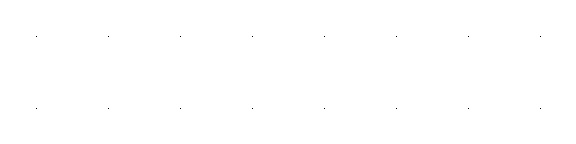

tensor([[ 0, 36, 36,  3],
        [ 1, 36, 36,  3],
        [ 2, 36, 36,  3],
        [ 3, 36, 36,  3],
        [ 4, 36, 36,  3],
        [ 5, 36, 36,  3],
        [ 6, 36, 36,  3],
        [ 7, 36, 36,  3]])

In [65]:
init_state = train(CA().to(device), pad_target.to(device), n_steps=4001).cpu()
print(init_state.shape, init_state.device, init_state.requires_grad)
print(torch.allclose(init_state, torch.zeros_like(init_state)))
print(init_state.shape[-2]//2, init_state.shape[-1]//2)

init_state[:, 3:, init_state.shape[-2]//2, init_state.shape[-1]//2] = 1.
print(torch.allclose(init_state, torch.zeros_like(init_state)))

x0 = to_rgba(reshape(init_state.cpu()))
print('x0 shape is {}'.format(x0.shape))
visualize_batch(x0, x0, 4)
x0.nonzero()

tensor([[36, 36,  3]])

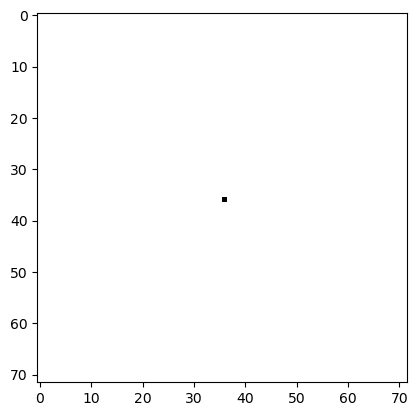

In [66]:
x0 = reshape(init_state)
plt.imshow(x0[0, ..., :4])
x0[0, ..., :4].nonzero()

In [35]:
init_state[..., init_state.shape[-2]//2, init_state.shape[-1]//2] = 1.
init_state.nonzero().shape

torch.Size([128, 4])

batch (before/after):


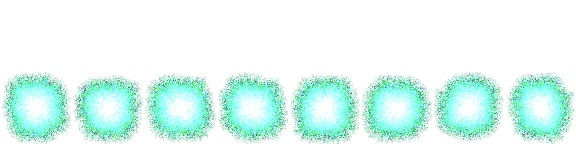

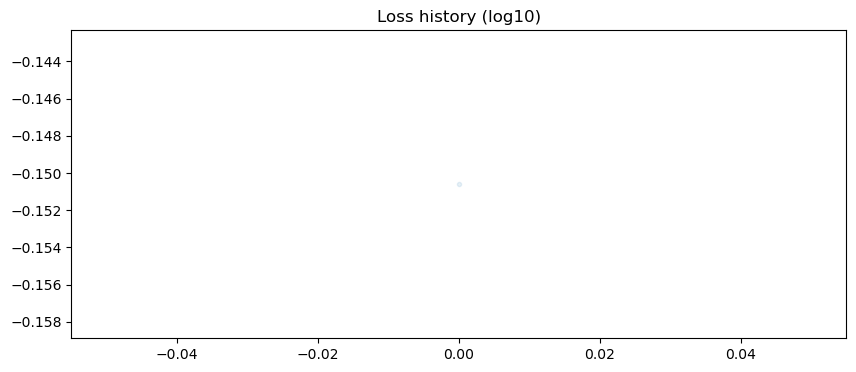

 step: 100, log10(loss): -1.326batch (before/after):


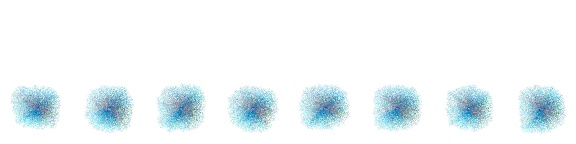

 step: 200, log10(loss): -1.597batch (before/after):


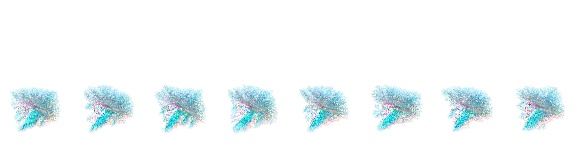

 step: 300, log10(loss): -1.773batch (before/after):


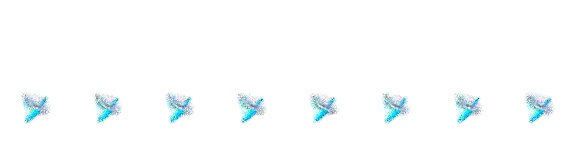

 step: 400, log10(loss): -1.662batch (before/after):


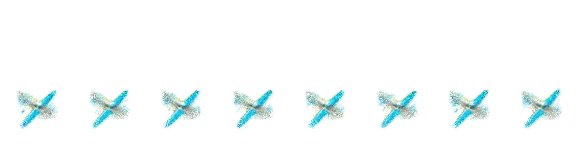

 step: 500, log10(loss): -2.066batch (before/after):


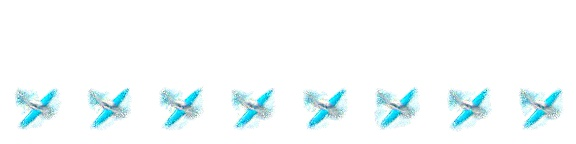

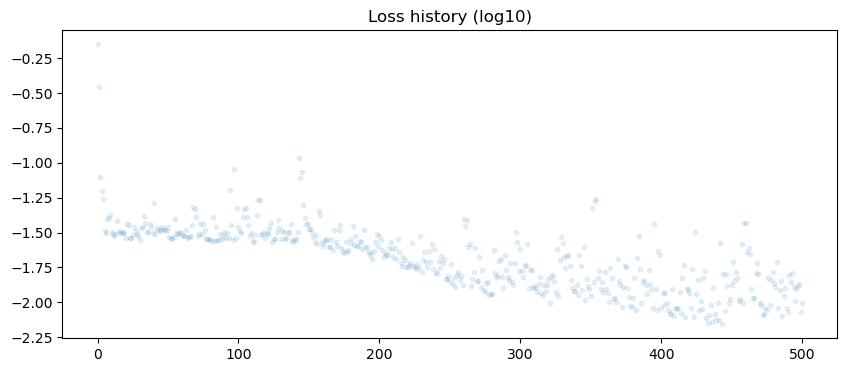

 step: 600, log10(loss): -2.165batch (before/after):


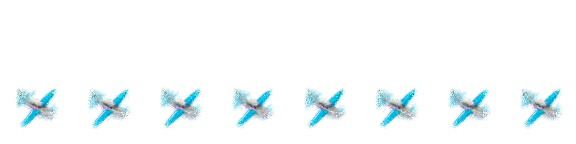

 step: 700, log10(loss): -2.035batch (before/after):


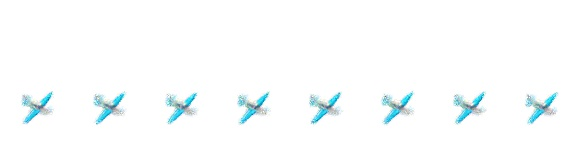

 step: 800, log10(loss): -1.737batch (before/after):


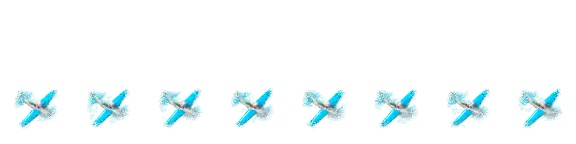

 step: 900, log10(loss): -1.779batch (before/after):


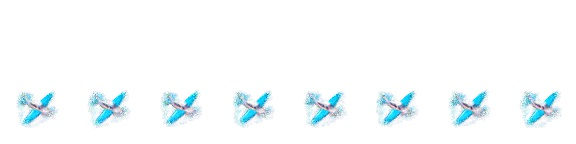

 step: 1000, log10(loss): -2.026batch (before/after):


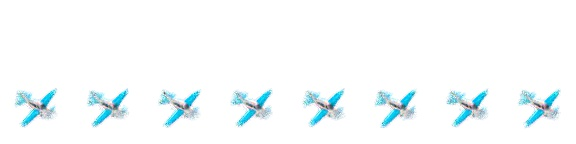

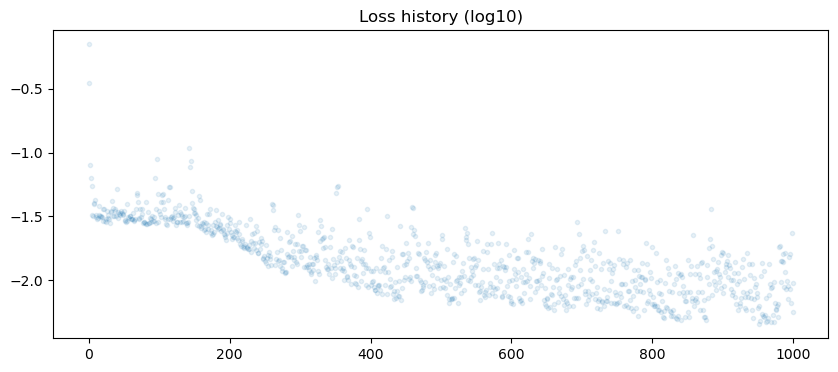

 step: 1100, log10(loss): -2.247batch (before/after):


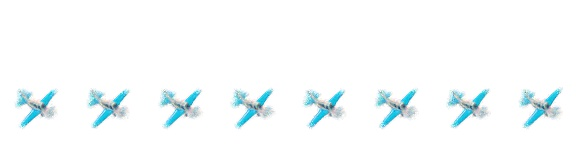

 step: 1200, log10(loss): -2.167batch (before/after):


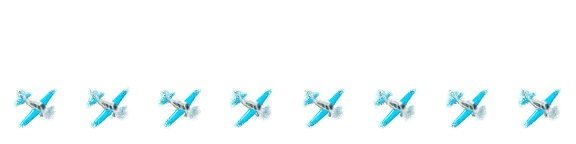

 step: 1300, log10(loss): -2.437batch (before/after):


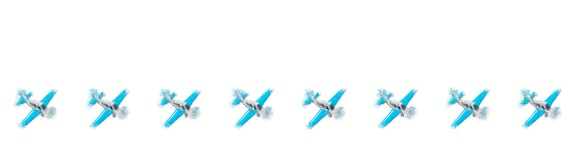

 step: 1400, log10(loss): -2.319batch (before/after):


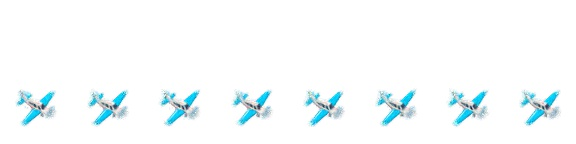

 step: 1500, log10(loss): -2.514batch (before/after):


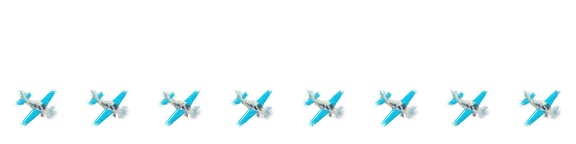

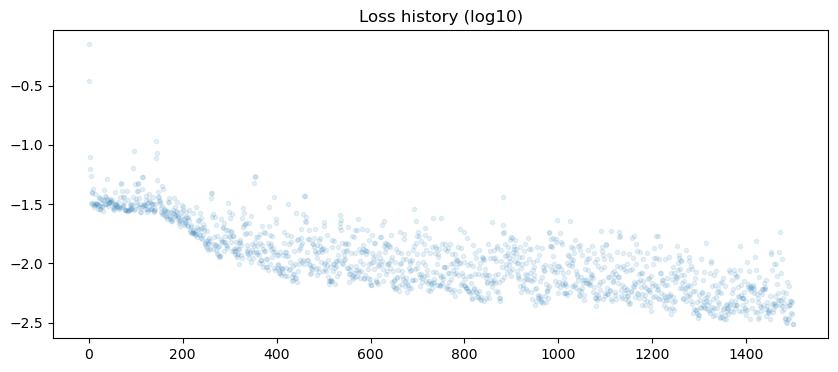

 step: 1600, log10(loss): -2.366batch (before/after):


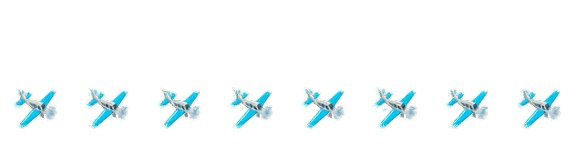

 step: 1700, log10(loss): -2.582batch (before/after):


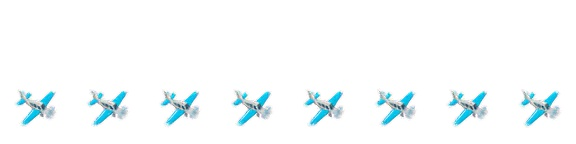

 step: 1800, log10(loss): -2.573batch (before/after):


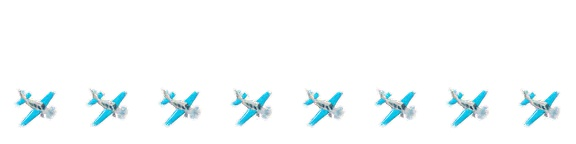

 step: 1900, log10(loss): -2.566batch (before/after):


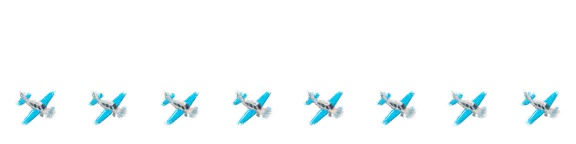

 step: 2000, log10(loss): -2.354batch (before/after):


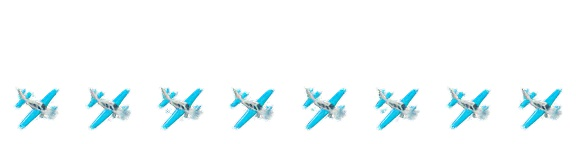

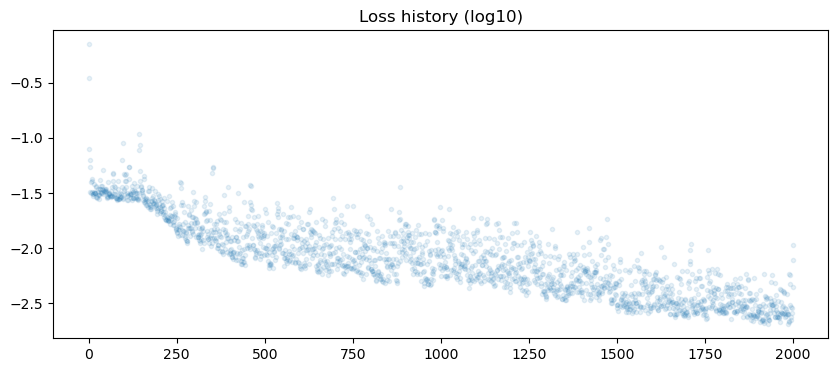

 step: 2100, log10(loss): -2.588batch (before/after):


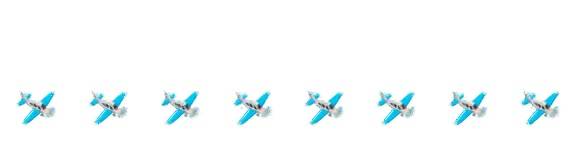

 step: 2200, log10(loss): -2.506batch (before/after):


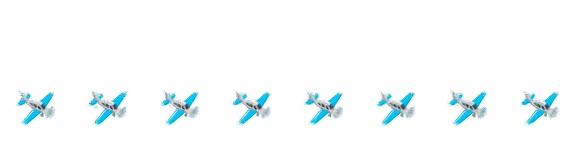

 step: 2300, log10(loss): -2.601batch (before/after):


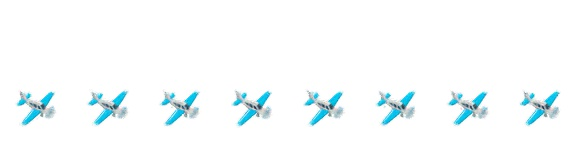

 step: 2400, log10(loss): -2.491batch (before/after):


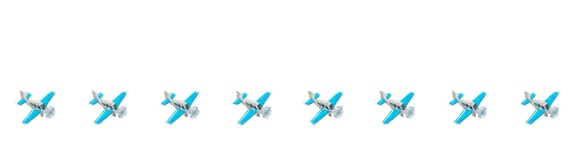

 step: 2500, log10(loss): -2.757batch (before/after):


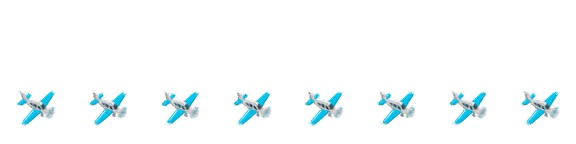

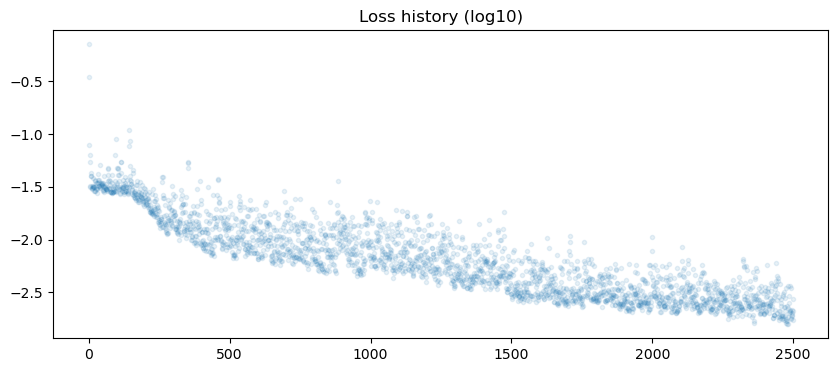

 step: 2600, log10(loss): -2.575batch (before/after):


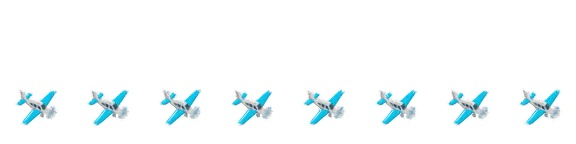

 step: 2700, log10(loss): -2.727batch (before/after):


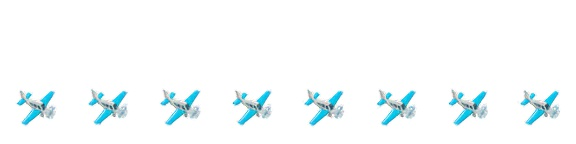

 step: 2800, log10(loss): -2.696batch (before/after):


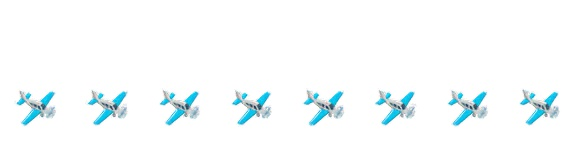

 step: 2900, log10(loss): -2.550batch (before/after):


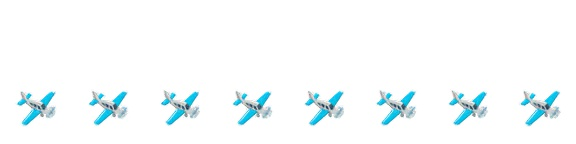

 step: 3000, log10(loss): -2.742batch (before/after):


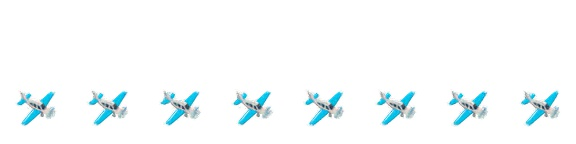

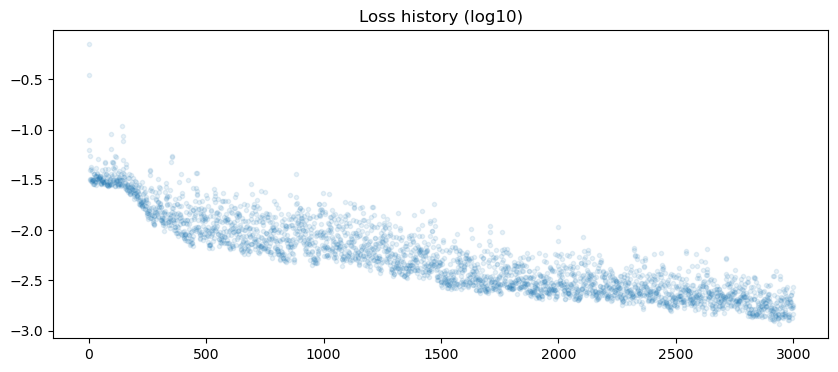

 step: 3100, log10(loss): -2.828batch (before/after):


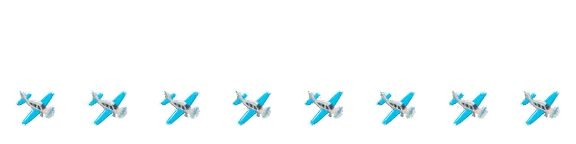

 step: 3200, log10(loss): -2.808batch (before/after):


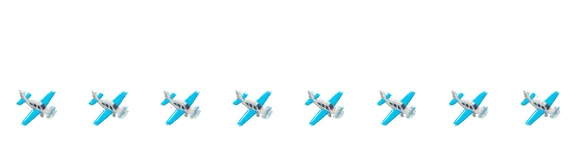

 step: 3300, log10(loss): -2.865batch (before/after):


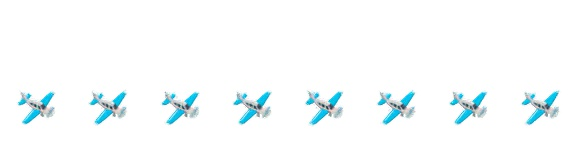

 step: 3400, log10(loss): -2.928batch (before/after):


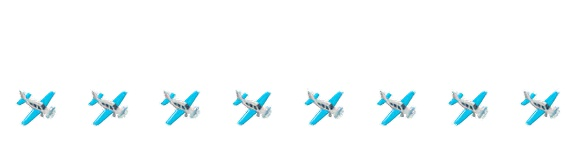

 step: 3500, log10(loss): -2.869batch (before/after):


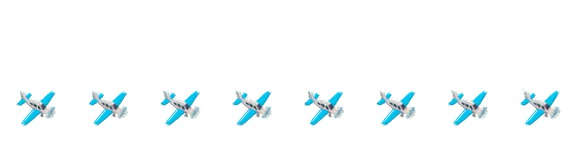

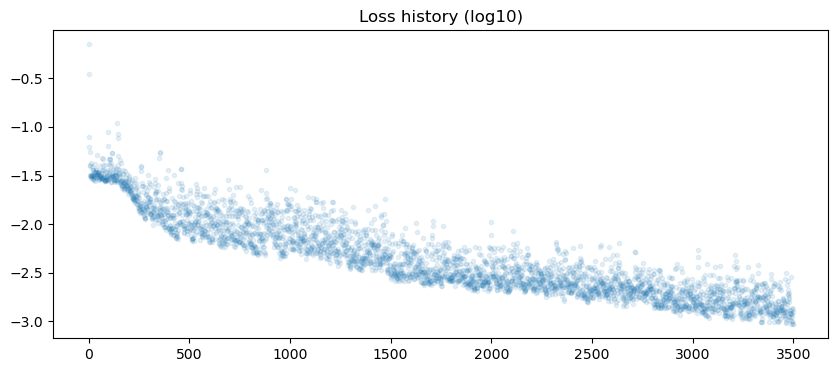

 step: 3600, log10(loss): -2.867batch (before/after):


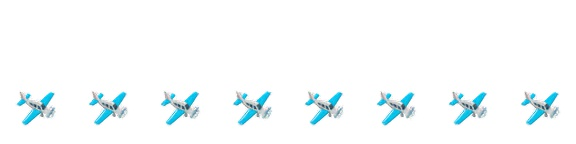

 step: 3700, log10(loss): -2.704batch (before/after):


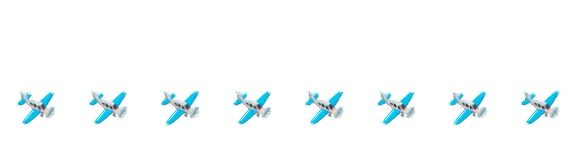

 step: 3800, log10(loss): -2.645batch (before/after):


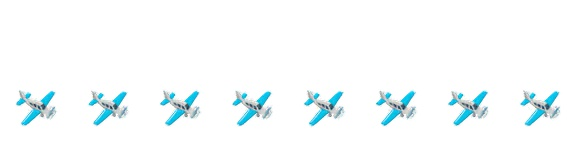

 step: 3900, log10(loss): -3.050batch (before/after):


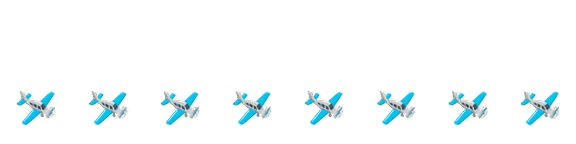

 step: 4000, log10(loss): -2.795batch (before/after):


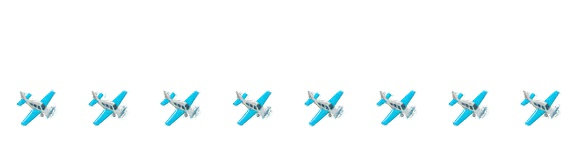

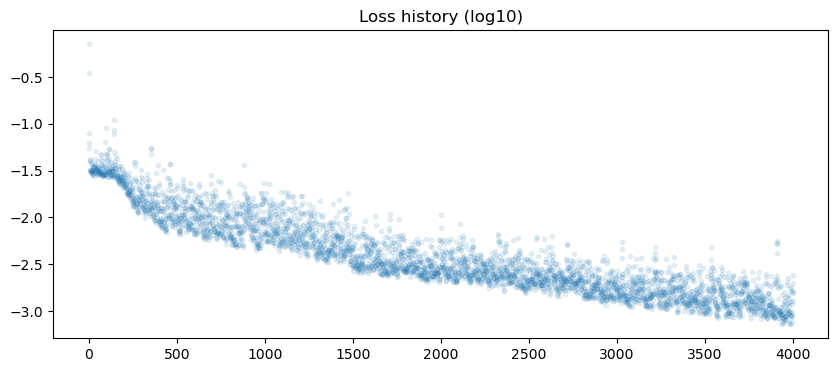

 step: 4001, log10(loss): -2.892

In [17]:
POOL_SIZE = 0
other_ca_model1 = CA()
other_loss_log1 = train(other_ca_model1.to(device), pad_target.to(device), n_steps=4001) 